# Task
Find the actual component values of the bandpass filter in fig. 1.

1. Compare the measured response voltage $U_a$ with the predicted response voltage under nominal component values.
2. Determine the root mean square error (rmse). 
3. Calculate the rmse for different values of $L$ and $C$.
4. Minimize the rmse function to find the actual component values.

![Circuit Diagramm](circuit.png)

In [180]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci

# Get Data

In [181]:
COIL=9e-3
CAPACITOR=1000e-6

def get_measured_voltage(filename):    
    # import measured data from file and create DataFrame
    with np.load(filename) as file:
        return pd.DataFrame({"time" : file["t_mess"], "measured" : file["u_a_mess"]})

def calculate_voltage(coil, capacitor):
    # return calculated voltage by creating LTI System with given parameters
    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    return INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

u_a = get_measured_voltage("messwerte.npz")
u_a["predicted"] = calculate_voltage(COIL, CAPACITOR) # append dataframe with predicted values

# Analysis
## Plot Expected and Measured Data

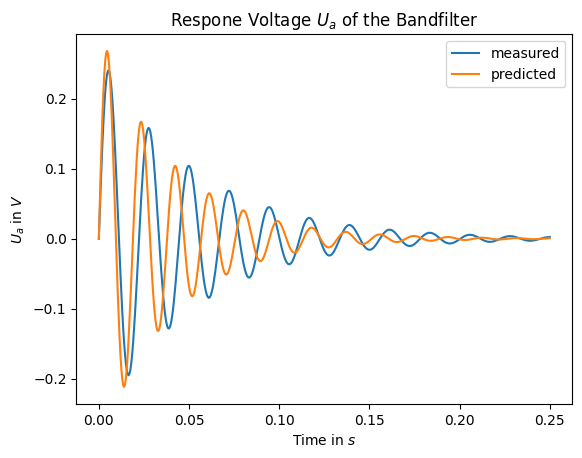

In [182]:
plt.plot(u_a["time"], u_a["measured"], label="measured")
plt.plot(u_a["time"], u_a["predicted"], label='predicted')

plt.title("Respone Voltage $U_a$ of the Bandfilter")
plt.xlabel("Time in $s$")
plt.ylabel("$U_a$ in $V$")
plt.legend()

plt.show()

## Calculate Root Mean Square Error

In [183]:
def root_mean_square_error(predicted): 
    # Calculate the root mean square error of 2 1D arrays
    return np.round(np.sqrt(1/len(predicted) * np.sum(np.square(np.subtract(predicted, u_a["measured"])))), 2)

rsme = root_mean_square_error(u_a["predicted"])
print(f"RSME with nominal values: {rsme} V")

RSME with nominal values: 0.06 V


# Modelling

## Create RMSE Grid

In [187]:
STEPS = 15
COIL_LOWER = 7e-3
COIL_UPPER = 12e-3
CAPACITOR_LOWER = 9 * 100e-6
CAPACITOR_UPPER = 16 * 100e-6

def resistor_list(lower, upper, steps):
    return np.linspace(lower, upper, steps)

def rsme_grid(coil_list, capacitor_list, steps):
    # find rsme for each coil and capacitor values
    rsme = np.zeros((steps, steps))   # reserve array space

    for i in range(steps):
        for j in range(steps):
            rsme[i][j] = root_mean_square_error(calculate_voltage(coil_list[i], capacitor_list[j]))

    return rsme

coil_list = resistor_list(COIL_LOWER, COIL_UPPER, STEPS)
capacitor_list = resistor_list(CAPACITOR_LOWER, CAPACITOR_UPPER, STEPS)

x, y = np.meshgrid(coil_list, capacitor_list)

Z = rsme_grid(coil_list, capacitor_list, STEPS)

## Plot RSME Contour and Surface

C:\Users\janho\AppData\Local\Temp\ipykernel_22200\195494105.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(x, y, Z, label="RSME")


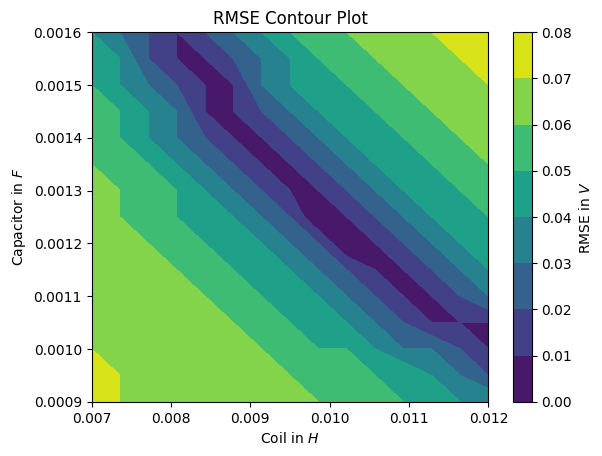

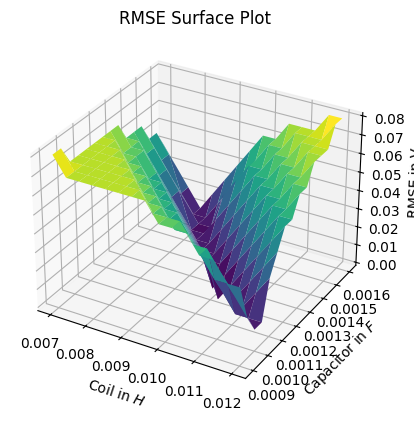

In [185]:
# Create Contour Plot
plt.contourf(x, y, Z, label="RSME")
plt.title('RMSE Contour Plot')
plt.xlabel('Coil in $H$')
plt.ylabel('Capacitor in $F$')
plt.colorbar(label='RMSE in $V$')
plt.show()

# Create a 3D plot
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x, y, Z, cmap='viridis')
plt.title('RMSE Surface Plot')
ax.set_xlabel('Coil in $H$')
ax.set_ylabel('Capacitor in $F$')
ax.set_zlabel('RMSE in V')
plt.show()

## Minimize rsme with variable parameters

In [189]:
initial_guess = [COIL, CAPACITOR]

result = sci.optimize.minimize(rsme_grid, initial_guess, args=(STEPS))
# print(result)


# best_coil, best_capacitor = result.x
# min_rmse = result.fun

# print(f"Optimal COIL: {best_coil}, Optimal CAPACITOR: {best_capacitor}, Minimum RMSE: {min_rmse}")

TypeError: rsme_grid() missing 1 required positional argument: 'steps'